<img src="https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn4/images/flappy_bird_demp.gif" width="144" height="256"/>

The implementation is based these references:
- [DeepLearningFlappyBird](https://github.com/yenchenlin/DeepLearningFlappyBird)
- [Deep Q-Learning for Atari Breakout](https://keras.io/examples/rl/deep_q_network_breakout/)



In [1]:
%pip install pygame
%pip install opencv-python
import sys
sys.path.append('/utils')
import os
os.chdir('/utils')
import numpy as np
import cv2
import wrapped_flappy_bird as flappy_bird
from collections import deque
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [2]:
num_actions = 2

# initiate a game
game = flappy_bird.GameState()

# get the first state by doing nothing
do_nothing = np.zeros(num_actions)
do_nothing[0] = 1
image, reward, terminal = game.frame_step(do_nothing)

print('shape of image:', image.shape)
print('reward: ', reward)
print('terminal: ', terminal)

shape of image: (288, 512, 3)
reward:  0.1
terminal:  False


In [3]:
for i in range(587):
    
    # choose a random action 
    action = np.random.choice(num_actions)
    
    # create the corresponding one-hot vector
    action_vec = np.zeros(num_actions)
    action_vec[action] = 1

    # take the action and observe the reward and the next state
    image, reward, terminal = game.frame_step(action_vec)

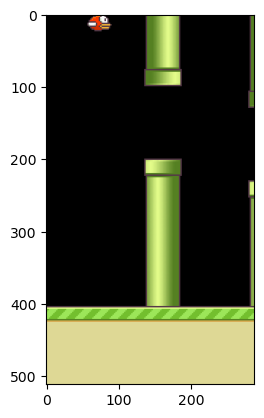

In [4]:
# show the image
import matplotlib.pyplot as plt
plt.imshow(image.transpose([1, 0, 2]))
plt.show()
plt.close()

### Preprocessing

Shape of the transformed image: (288, 512, 3)


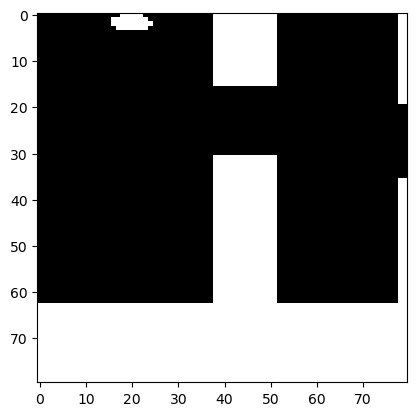

In [5]:
def resize_gray(frame):
    frame = cv2.cvtColor(cv2.resize(frame, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, frame = cv2.threshold(frame, 1, 255, cv2.THRESH_BINARY)
    return np.reshape(frame, (80, 80, 1))

image_transformed = resize_gray(image)
print('Shape of the transformed image:', image.shape)

# show the transformed image
_ = plt.imshow(image_transformed.transpose((1, 0, 2)), cmap='gray')

In [6]:
def preprocess(image_raw, current_state=None):
    # resize and convert to grayscale
    image = resize_gray(image_raw)
    # stack the frames
    if current_state is None:
        state = np.concatenate((image, image, image, image), axis=2)
    else:
        state = np.concatenate((image, current_state[:, :, :3]), axis=2)
    return state

###  Constructing the neural network

In [7]:
from tensorflow.keras import initializers
def create_q_model():
    state = layers.Input(shape=(80, 80, 4,))

    layer1 = layers.Conv2D(filters=32, kernel_size=8, strides=4, activation="relu",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(state)
    layer2 = layers.MaxPool2D(2, strides=2, padding="SAME")(layer1)
    layer3 = layers.Conv2D(filters=64, kernel_size=4, strides=2, activation="relu", 
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(layer2)
    layer4 = layers.Flatten()(layer3)
    q_value = layers.Dense(units=2, activation="linear", 
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(layer4)

    return keras.Model(inputs=state, outputs=q_value)

Plot the model summary to make sure that the network is the same as expected. 

In [8]:
model = create_q_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 19, 19, 32)        8224      
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          32832     
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                             

### Deep Q-learning

In [9]:
gamma = 0.99            # decay rate of past observations
step_size = 1e-4        # step size

In [10]:
observe = 10000            # timesteps to observe before training
replay_memory = 10000      # number of previous transitions to remember
batch_size = 32            # size of each batch

In [11]:
# value of epsilon
epsilon = 0.05

In [12]:
def dql_flappy_bird(model, optimizer, loss_function):

    # initiate a game
    game = flappy_bird.GameState()

    # store the previous state, action and transitions
    history_data = deque()

    # get the first observation by doing nothing and preprocess the image
    do_nothing = np.zeros(num_actions)
    do_nothing[0] = 1
    image, reward, terminal = game.frame_step(do_nothing)

    # preprocess to get the state
    current_state = preprocess(image_raw=image)
    
    # training
    t = 0

    while t < 50000:
        if epsilon > np.random.rand(1)[0]:
            # random action
            action = np.random.choice(num_actions)
        else:
            # compute the Q function
            current_state_tensor = tf.convert_to_tensor(current_state)
            current_state_tensor = tf.expand_dims(current_state_tensor, 0)
            q_value = model(current_state_tensor, training=False)
            
            # greedy action
            # your code here
            #-----------------#
            action = np.argmax(q_value.numpy()) 

        # take the action and observe the reward and the next state
        action_vec = np.zeros([num_actions])
        action_vec[action] = 1
        image_raw, reward, terminal = game.frame_step(action_vec)
        next_state = preprocess(current_state=current_state, 
                                image_raw=image_raw)
        
        # store the observation
        history_data.append((current_state, action, reward, next_state, 
                            terminal))
        if len(history_data) > replay_memory:
            history_data.popleft()  # discard old data

        # train if done observing
        if t > observe:

            # sample a batch
            batch = random.sample(history_data, batch_size)
            state_sample = np.array([d[0] for d in batch])
            action_sample = np.array([d[1] for d in batch])
            reward_sample = np.array([d[2] for d in batch])
            state_next_sample = np.array([d[3] for d in batch])
            terminal_sample = np.array([d[4] for d in batch])

            # compute the updated Q-values for the samples
            # your code here
            #-----------------#
            # Inside the training loop, after sampling a batch
            current_q_values = model(tf.convert_to_tensor(state_sample), training=True)
            current_q_values_actions = tf.reduce_sum(
            current_q_values * tf.one_hot(action_sample, depth=num_actions), axis=1)

            q_values_next = model(tf.convert_to_tensor(state_next_sample), training=False)
            max_q_values_next = tf.reduce_max(q_values_next, axis=1)

            # Compute the updated Q-values
            # Your existing calculation of updated_q_value is correct
            updated_q_value = reward_sample + gamma * (1 - terminal_sample) * max_q_values_next


            # train the model on the states and updated Q-values
            with tf.GradientTape() as tape:
                # compute the current Q-values for the samples
                # your code here
                #-----------------#
                current_q_values = model(tf.convert_to_tensor(state_sample), training=True)
                current_q_values_actions = tf.reduce_sum(current_q_values * tf.one_hot(action_sample, depth=num_actions), axis=1)

                # compute the loss
                loss = loss_function(updated_q_value, current_q_values_actions)

            # backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        else:
            loss = 0

        # update current state and counter
        current_state = next_state
        t += 1

        # print info every 500 steps
        if t % 500 == 0:
            print(f"STEP {t} | PHASE {'observe' if t<=observe else 'train'}", 
                  f"| ACTION {action} | REWARD {reward} | LOSS {loss}")

In [13]:
def playgame(start_from_ckpt=False, ckpt_path=None):

    np.random.seed(4)

    if start_from_ckpt:
        # if you want to start from a checkpoint
        model = keras.models.load_model('ckpt_path')
    else:
        model = create_q_model()

    # specify the optimizer and loss function
    optimizer = keras.optimizers.legacy.Adam(learning_rate=step_size, clipnorm=1.0)
    loss_function = keras.losses.MeanSquaredError()

    # play the game
    dql_flappy_bird(model=model, optimizer=optimizer, loss_function=loss_function)

In [14]:
playgame()

STEP 500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 1000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 1500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 2000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 2500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 3000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 3500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 4000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 4500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 5000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 5500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 6000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 6500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 7000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 7500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 8000 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 0
STEP 8500 | PHASE observe | ACTION 1 | REWARD 0.1 | LOSS 

KeyboardInterrupt: 

### The following was a test to see performance with only 100 steps before the training phase

In [15]:
observe = 100            # timesteps to observe before training
playgame()

STEP 500 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 2.422938108444214
STEP 1000 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.12893174588680267
STEP 1500 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.025578347966074944
STEP 2000 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.020953886210918427
STEP 2500 | PHASE train | ACTION 1 | REWARD 0.1 | LOSS 0.07277293503284454
STEP 3000 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.015047937631607056
STEP 3500 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.009646087884902954
STEP 4000 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.025542743504047394
STEP 4500 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.0069857025519013405
STEP 5000 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.006203163880854845
STEP 5500 | PHASE train | ACTION 1 | REWARD 0.1 | LOSS 0.0075559127144515514
STEP 6000 | PHASE train | ACTION 0 | REWARD 0.1 | LOSS 0.016295243054628372
STEP 6500 | PHASE train | ACTION 1 | REWARD 0.1 | LOSS 0.008017242886126041
STEP 7000 | PHAS

### This had a similar performance near the final steps but showed much quicker training and much faster improvement. Bird passed first pipe at step 10000 and played near perfectly by 50000